# Organize data

In [1]:

import os 
import pandas as pd


In [3]:



## Manually annotated objects ##
info_db_file = "../../Datasets/Objects_Database/Selected_Objects_Information.csv"

info_db_df = pd.read_csv(info_db_file)
info_db_df["set"] = ["set"]*info_db_df.shape[0]

## YOLO DB images ##
set_type_list = ["train", "valid", "test"]

image_name_list = []

for set_type in set_type_list:

    db_path = f"../../Datasets/IP.v4-v4.yolov5pytorch/{set_type}/images/"

    img_list = os.listdir(db_path)
    print("Set Lenght:", len(img_list))
    
    for img_file in img_list:

        image_name = img_file.split("_png")[0]

        image_name_list.append(image_name)

        cond = info_db_df["image_name"]==image_name

        if(cond.sum() <= 1):
            # print(f"Len: {cond.sum()}, Name: {image_name}")
            idx_list = info_db_df.loc[cond, "set"].index
            info_db_df.loc[idx_list, "set"] = [set_type]
        else:
            idx_list = info_db_df.loc[cond, "set"].index
            info_db_df.loc[idx_list, "set"] = [set_type]*len(idx_list)
        

info_db_df.head()       



Set Lenght: 246
Set Lenght: 70
Set Lenght: 34


,image_name,docid,label,x,y,w,h,logo_label,set
0,bjn43c00-page02_1,bjn43c00-page02_1_obj2.png,logo,724,209,209,216,4,train
1,gpq38e00-page02_2,gpq38e00-page02_2_obj0.png,logo,852,101,973,406,2,train
2,hna35f00,hna35f00_obj2.png,logo,141,24,335,130,1,train
3,gcv85f00,gcv85f00_obj0.png,logo,68,35,229,201,8,train
4,ifw98c00,ifw98c00_obj0.png,logo,116,307,1467,197,3,train


In [4]:
info_db_df["set"].value_counts()

set
train    464
valid    109
test      63
set        3
Name: count, dtype: int64

In [5]:
len(info_db_df["image_name"].unique())

info_db_df.index = list(info_db_df["image_name"])

In [6]:
info_db_df_2 = info_db_df.drop(index=image_name_list)
info_db_df_2

,image_name,docid,label,x,y,w,h,logo_label,set
adh36e00-page2_1,adh36e00-page2_1,adh36e00-page2_1_obj0.png,logo,937,5,829,411,2,set
adh36e00-page2_1,adh36e00-page2_1,adh36e00-page2_1_obj5.png,other,481,2418,1808,492,0,set
adh36e00_2,adh36e00_2,adh36e00_2_obj4.png,signature,1162,2364,994,428,0,set


In [7]:

info_db_df = info_db_df.loc[image_name_list, :]

info_db_df["set"].value_counts()

set
train    464
valid    109
test      63
Name: count, dtype: int64

In [8]:
info_db_df["label"].value_counts()

label
other        212
logo         212
signature    212
Name: count, dtype: int64

In [9]:
len(info_db_df["image_name"].unique())

350

In [10]:
info_db_file = "../../Datasets/Objects_Database/2_Selected_Objects_Information.csv"
info_db_df.to_csv(info_db_file, index=False)

# Model Evaluation

## Libraries

In [12]:


import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import os
import shutil


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score, cohen_kappa_score, classification_report, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import GradientBoostingClassifier


from sklearn import svm
from joblib import dump, load



## Classes

In [13]:

############################################################################################
####                         Class to evaluate whatever metric                          ####
############################################################################################

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
# mean_squared_error

def evaluating(metric_class, key, metric_dict, predictions_dict):
    ## Get parameters ##
    parameters = metric_class.get_params()
    ## Loop to assign data ##
    for param in metric_dict["data"]:
        parameters[param] = predictions_dict[param]    
    ## Loop to assign other parameters ##
    for param in metric_dict["params"]:
        parameters[param[0]] = param[1]
    
    ## Set the parameters ##
    metric_class.set_params(**parameters)
    
    ## Compute the score ##
    value = getattr(metric_class, metric_dict["function"])()
    
    return value

class MetricEvaluation():
    def __init__(self, y_true=[], y_pred=[], y_score=[], average="binary", weights=None):
        
        ## Assign parameters ##
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_score = y_score
        
        self.average = average # F1, Recall, Precision
        self.weights = weights # Cohen 
    
    ############################################################
    ####                   Classification                   ####
    ############################################################

    # Accuracy, Balanced_Accuracy, F1_Score, Precision_Score, Recall_Score, Specificity_Score, Cohen_Kappa_Score

    def Accuracy(self):
        val = accuracy_score(y_true=self.y_true, y_pred=self.y_pred)
        return val
    
    def Balanced_Accuracy(self):
        val = balanced_accuracy_score(y_true=self.y_true, y_pred=self.y_pred)
        return val
    
    def F1_Score(self):
        val = f1_score(y_true=self.y_true, y_pred=self.y_pred, average=self.average)
        return val
    
    def Precision_Score(self):
        val = precision_score(y_true=self.y_true, y_pred=self.y_pred, average=self.average)
        return val
    
    def Recall_Score(self): # Sensitivity
        val = recall_score(y_true=self.y_true, y_pred=self.y_pred, average=self.average)
        return val
    
    def Specificity_Score(self):
        tn, fp, fn, tp = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred).ravel()
        return tn/(tn+fp)#*100
    
    def Cohen_Kappa_Score(self):
        val = cohen_kappa_score(y1=self.y_true, y2=self.y_pred, weights=self.weights)
        return val
    
    ############################################################
    
    ############################################################
    ####                     Regression                     ####
    ############################################################
    def Mean_Absolute_Error(self):
        val = mean_absolute_error(y_true=self.y_true, y_pred=self.y_pred)
        return val
                                
    def Mean_Squared_Error(self):
        val = mean_squared_error(y_true=self.y_true, y_pred=self.y_pred)
        return val
    
    def R2(self):
        val = r2_score(y_true=self.y_true, y_pred=self.y_pred)
        return val

    def Pearson(self):
        val, _ = pearsonr(x=self.y_true, y=self.y_pred)
        return val
    
    def Spearman(self):
        val, _ = spearmanr(a=self.y_true, b=self.y_pred)
        return val
    
    ############################################################
    
    
    def get_params(self):
        
        ## Dict to save parameters ##
        params_dict = {}
        
        ## Save all parameters ##
        params_dict["y_true"] = self.y_true
        params_dict["y_pred"] = self.y_pred
        params_dict["y_score"] = self.y_score
        params_dict["average"] = self.average
        params_dict["weights"] = self.weights

        ## Return dict of parameters ##
        return params_dict
    
    def set_params(self, y_true, y_pred, y_score, average, weights):
        
        ## Assign all parameters ##
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_score = y_score
        self.average = average
        self.weights = weights
          
        return self

 ############################################################################################     



## Functions

In [21]:
def create_dir(path):
    dirs = path.split("/")
    # print(dirs)
    n_path = ""
    for i in range(len(dirs)):
        
        n_path = os.path.join(n_path, dirs[i])
        # print(n_path)
        a = os.path.isdir(n_path)   
        # print(a) 
        if(not(a)):
            os.mkdir(n_path)  


def remove_dir(dir_path):
    shutil.rmtree(dir_path)

def report(y_true, y_pred):
    #### Mostrar la microclasificación ####
    report_str = classification_report(y_true, y_pred, digits=4, output_dict=False)
    report_table = classification_report(y_true, y_pred, digits=4, output_dict=True)
    report_table = pd.DataFrame.from_dict(report_table).T

    return report_table, report_str


def confusion_matrix_plot(y_true, y_pred, file_save="",labels=[], size=8, fz=15):
    
    cf_matrix = confusion_matrix(y_true, y_pred, normalize=("true"))
    cf_matrix_v = confusion_matrix(y_true, y_pred)
    
    if (len(labels)==0):
        labels = np.unique(y_true)
        print(labels)
    
    # Define a color map for the heatmap
    cmap = sns.color_palette("Blues", as_cmap=True)
    
    plt.figure(figsize = (size,size))
    heatmap = sns.heatmap(cf_matrix, annot=False, cmap=cmap, fmt='d', xticklabels=labels, yticklabels=labels, square=True, cbar=True)
    # heatmap = sns.heatmap(data, annot=False, fmt='d', cmap=cmap)
    
    # Calculate and display percentages
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix[i])):
            text = f"{cf_matrix[i][j]*100: 0.2f}% ({cf_matrix_v[i][j]})"
            
            # Calculate the background color at the center of the cell
            cell_bg_color = np.mean(cmap(cf_matrix[i][j]))
            print(i,j, cell_bg_color)
            # Choose a text color based on the background color
            text_color = 'black' if cell_bg_color > 0.7 else 'white'
                    
            heatmap.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color)
    
    # ax.set_xticklabels(ax.get_xticklabels(),rotation = 40)
    # ax.set_yticklabels(ax.get_xticklabels(),rotation = 40)
    

    plt.xlabel("Predicted",fontsize=fz-2)
    plt.ylabel("Real",fontsize=fz-2)
    plt.title("Confusion Matrix",fontsize=fz)
    plt.tight_layout()
    
    if(file_save!=""):
        plt.savefig(file_save)
    
    plt.show()
    
    return cf_matrix


def nested_cross_validation(X, y, docid, results_file, model_info_dict, evaluation_data_dict, evaluation_metrics_dict):
    
    ## Convert features and labes to arrays ##
    X = np.asarray(X)
    y = np.asarray(y)
    
    ## Print model information ##
    print("\n############################")
    print(model_info_dict["model_name"])
    print("############################\n")
    
    
    ## To store the fitted parameters ##
    train_parameters_dict = {}
    ## Define the number of rows according to the folds ##
    train_parameters_dict["fold"] = np.arange(model_info_dict["kfold"])
    ## Initialize key to sabe the data ##
    for key in model_info_dict["params"].keys():
        train_parameters_dict[key] = []
    
    ## Dictionary to store the needed predictions ##
    test_predictions_dict = {}
    for key in evaluation_data_dict.keys():
        test_predictions_dict[key] = []
    
    ## dictionary to accumulate the predicted data in all folds ##
    test_data_results_dict = {}
    for key in evaluation_data_dict.keys():
        test_data_results_dict[key] = []
    
    ## to store the metrics ##
    metric_evaluation = MetricEvaluation()
    test_metrics_results_dict = {}
    ## Define the number of rows according to the folds ##
    test_metrics_results_dict["fold"] = np.arange(model_info_dict["kfold"])
    ## Initialize key to sabe the data ##
    for key in evaluation_metrics_dict.keys():
        test_metrics_results_dict[key] = []
    
                
    ## Instantiate crossvalidation ##
    if(model_info_dict["model_type"].lower() == "regression"):
        ## Crossvalidation for regression data ##
        skf = KFold(n_splits=model_info_dict["kfold"], shuffle=(True), random_state=21)
        to_split = {"X": X}
        ## Instantiate grid search crossvalidation ##
        skf_gs = KFold(n_splits=model_info_dict["kfold"], shuffle=(True), random_state=31)
        
    else:
        ## Crossvalidation for classification ##    
        skf = StratifiedKFold(n_splits=model_info_dict["kfold"], shuffle=(True), random_state=21)
        to_split = {"X": X,
                    "y": y}
        
        ## Instantiate grid search crossvalidation ##
        skf_gs = StratifiedKFold(n_splits=model_info_dict["kfold"], shuffle=(True), random_state=31)
    
    ## Loop with splitted data ##
    for train_index, test_index in tqdm(skf.split(**to_split)):
        
        #################################################################
        ####                        split data                       ####
        #################################################################
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        docid_train, docid_test = docid[train_index], docid[test_index]
        
        #################################################################
        

        #################################################################
        ####                     Normalize data                      ####
        #################################################################
        normalize_transform = StandardScaler().fit(X_train)
        X_train = normalize_transform.transform(X_train)
        X_test = normalize_transform.transform(X_test)
        #################################################################


        #################################################################
        ####                       grid search                       ####
        #################################################################
        
        #### Train grid search ####
        ## Internally train data is splitted into train and val according to skf_gs folds ##
        clf = GridSearchCV(model_info_dict["model"](), 
                                           model_info_dict["params"], 
                                           scoring=model_info_dict["scoring"], 
                                           cv=skf_gs, 
                                           verbose=3,
                                           n_jobs=model_info_dict["n_jobs"])
        clf.fit(X_train,y_train)
        #################################################################


        #################################################################
        ####                       Train model                       ####
        #################################################################
        ## Initialize new model ##
        classifier = model_info_dict["model"]()
        ## Get deault parameters ##
        parameters = classifier.get_params()
        
        ## Replace the best parameters trained ##
        for key in clf.best_params_.keys():
            ## Assign best parameters ##
            parameters[key] = clf.best_params_[key]
            ## Store best parameters ##
            train_parameters_dict[key].append(clf.best_params_[key])
        
        ## Set the new parameters ##
        classifier.set_params(**parameters)
        ## Train model ##
        classifier.fit(X_train, y_train)
        
        #################################################################


        #################################################################
        ####                    Prediction process                   ####
        #################################################################
                
        ## Perform the indicated evaluations ##
        for key in evaluation_data_dict.keys():
            if("test" in evaluation_data_dict[key]):
                ## Save real featrues ##
                test_predictions_dict[key] = y_test.copy()
            elif("docid" in evaluation_data_dict[key]):
                ## Save real featrues ##
                test_predictions_dict[key] = docid_test.copy()
            else:
                ## Save the predictions needed ##
                test_predictions_dict[key] = getattr(classifier, evaluation_data_dict[key])(X_test)
            
            ## Accumalate all results ##
            test_data_results_dict[key].extend(test_predictions_dict[key])
    
        #################################################################
        
        
        #################################################################
        ####                      Compute metrics                    ####
        #################################################################
        # for key in evaluation_metrics_dict.keys():
        #     ## Loop trought selected metrics and saving ##
        #     test_metrics_results_dict[key].append(evaluation_metrics_dict[key](test_predictions_dict["y_true"], test_predictions_dict["y_pred"]))
        
        for key in evaluation_metrics_dict.keys():         
            value = evaluating(metric_evaluation, key, evaluation_metrics_dict[key], test_predictions_dict)
            # print(key, ":",value)
            test_metrics_results_dict[key].append(value)

        #################################################################
        
        
    #################################################################
    ####                        Data saving                      ####
    #################################################################
    
    #### Results of selected metrics ####
    metrics_results_df = pd.DataFrame.from_dict(test_metrics_results_dict)
    ## Compue metrics mean ##
    mean = metrics_results_df.mean().to_frame()
    mean.loc["fold", 0] = "Mean"
    ## Compute metrics std ##
    std = metrics_results_df.std().to_frame()
    std.loc["fold", 0] = "STD"
    ## Concatenate results ##
    metrics_results_df = pd.concat([metrics_results_df, mean.T, std.T], axis=0)
    
    #### Selected parameters during training process ####
    train_parameters_df = pd.DataFrame.from_dict(train_parameters_dict)
    
    #### Predicted values for test data ####
    test_data_results_df = pd.DataFrame.from_dict(test_data_results_dict)
    
    #### Report doesn't make sense for regression ####
    if(model_info_dict["model_type"].lower() == "regression"):
        test_report = pd.DataFrame([])
    else:
        test_report, _ = report(test_data_results_df["y_true"], test_data_results_df["y_pred"])
    
    
    with pd.ExcelWriter(results_file) as writer:  
        
        metrics_results_df.to_excel(writer, sheet_name="metrics", index=(False))
        test_report.to_excel(writer, sheet_name="test_report")
        train_parameters_df.to_excel(writer, sheet_name="training_parameters", index=(False))
        test_data_results_df.to_excel(writer, sheet_name="predicted_data", index=(False))
        
    #################################################################

    
    return test_data_results_df



## Nested crossvalidation

In [23]:
label_map = {
    "logo": 0,
    "signature": 1,
    "other": 2
}

list(label_map.keys())

['logo', 'signature', 'other']

X train hape: (573, 756) - Y train shape: (573,) - Docid train Shape(573,)
X train type: <class 'pandas.core.frame.DataFrame'> - Y train type: <class 'pandas.core.series.Series'> - Docid type Shape<class 'pandas.core.series.Series'>
C variation: min:0.001, max:1000.0, Amount:7
Gamma variation: min:0.001, max:1000.0, Amount:7
Kernels: ['rbf', 'linear']

############################
HOG_Feat(756)_img(256, 512)_O(9)_C(64)_B(2)_N(L2-Hys)
############################



0it [00:00, ?it/s]

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 2/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 3/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 4/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 5/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.869 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.935 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.858 total time=   0.0s
[CV 4/5] END C=0.

1it [00:23, 23.45s/it]

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 2/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 3/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 4/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 5/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.860 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.870 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.881 total time=   0.0s
[CV 4/5] END C=0.

2it [00:47, 23.70s/it]

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.180 total time=   0.1s
[CV 2/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 3/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 4/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 5/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.946 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.934 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.847 total time=   0.0s
[CV 4/5] END C=0.

3it [01:10, 23.58s/it]

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 2/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 3/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 4/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 5/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.848 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.880 total time=   0.0s
[CV 4/5] END C=0.

4it [01:42, 26.63s/it]

Fitting 5 folds for each of 98 candidates, totalling 490 fits
[CV 1/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 2/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 3/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 4/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.170 total time=   0.1s
[CV 5/5] END C=0.001, gamma=0.001, kernel=rbf, probability=True, random_state=21;, score=0.173 total time=   0.1s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.923 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.913 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear, probability=True, random_state=21;, score=0.859 total time=   0.0s
[CV 4/5] END C=0.

5it [02:14, 26.87s/it]
/tmp/ipykernel_80134/4249120656.py:236: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean.loc["fold", 0] = "Mean"
/tmp/ipykernel_80134/4249120656.py:239: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'STD' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  std.loc["fold", 0] = "STD"


0 0 0.4425913110342176
0 1 0.9806997308727413
0 2 0.9776855055747788
1 0 0.9822068435217224
1 1 0.4526797385620915
1 2 0.9686428296808919
2 0 0.9641214917339485
2 1 0.9822068435217224
2 2 0.46024605920799694


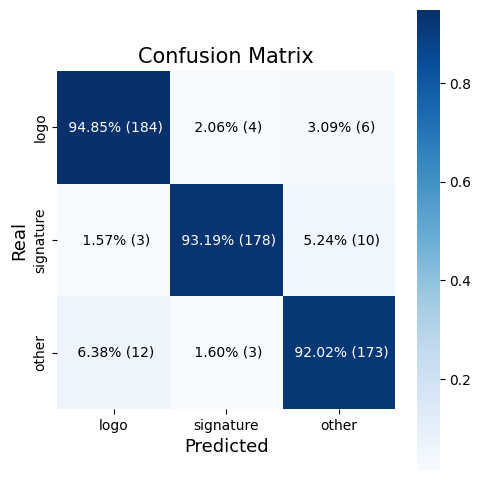

In [25]:


#################################################################
####                     Define files                        ####
#################################################################

db_path = "../../Datasets/Objects_Database/Features"

#### Features files ####

# features_name = "HOG_F(288)_img(256, 512)_O(9)_C(64)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(756)_img(256, 512)_O(9)_C(64)_B(2)_N(L2-Hys).csv"
# features_name = "HOG_F(1152)_img(256, 512)_O(9)_C(32)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(3780)_img(256, 512)_O(9)_C(32)_B(2)_N(L2-Hys).csv"
# features_name = "HOG_F(4608)_img(256, 512)_O(9)_C(16)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(16740)_img(256, 512)_O(9)_C(16)_B(2)_N(L2-Hys).csv"
# features_name = "HOG_F(18432)_img(256, 512)_O(9)_C(8)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(70308)_img(256, 512)_O(9)_C(8)_B(2)_N(L2-Hys).csv"

features_file = "HOG_Feat(756)_img(256, 512)_O(9)_C(64)_B(2)_N(L2-Hys).csv"
features_name = features_file.split(".")[0]



#### Results file ####
results_path = f"../../Datasets/Objects_Database/Results/{features_name}"
create_dir(results_path)

#################################################################


#### Load features ####
features_file = os.path.join(db_path, features_file)
features_df = pd.read_csv(features_file)
feat_cols = [col for col in features_df.columns if("hog_" in col)]

cond = (features_df["set"]=="train") | (features_df["set"]=="valid")
train_df = features_df.loc[cond, :].reset_index(drop=True)
##############################

#### Split docid ####
docid = train_df["docid"]
#### Split features ####
X = train_df.loc[:,feat_cols].reset_index(drop=True)
#### Create labels ####
label_map = {
    "logo": 0,
    "signature": 1,
    "other": 2
}
train_df["label"] = train_df["label"].map(label_map)
y = train_df["label"].copy()


print(f"X train hape: {X.shape} - Y train shape: {y.shape} - Docid train Shape{docid.shape}")
print(f"X train type: {type(X)} - Y train type: {type(y)} - Docid type Shape{type(docid)}")


#################################################################
####                      SVM Model                          ####  
#################################################################

## Select C parameter ##
min = 1e-3
max = 1e3
n = int(np.log10(max)-np.log10(min))+1

print(f"C variation: min:{min}, max:{max}, Amount:{n}")
C = np.geomspace(min, max, n)

## Select gamma parameter ##
min = 1e-3# 0.00001
max = 1e3
n = int(np.log10(max)-np.log10(min))+1

print(f"Gamma variation: min:{min}, max:{max}, Amount:{n}")
gamma = np.geomspace(min, max, n)

## Select kernels to train ##
kernels = ["rbf", "linear"]
print("Kernels:", kernels)

model_information = {
        "model_name": features_name,
        "scoring": "f1_weighted",# accuracy, balanced_accuracy, f1_weighted, recall_weighted,
        "model_type": "classification",
        "model_type_2":"SVM", 
        "model": svm.SVC,
        "kfold": 5,
        "n_jobs": None,
        "params":{
            "C": C,
            "gamma": gamma,
            "kernel": kernels,
            "probability": [True],
            "random_state": [21]
            }
        }

#################################################################

# #################################################################
# ####                    Gradient Boosting                    ####  
# #################################################################

# # n_estimators_list = [10, 100, 1000]
# # loss_list = ["log_loss", "exponential"]
# # ## Select learning rate parameter ##
# # min = 1e-3
# # max = 10
# # n = int(np.log10(max)-np.log10(min))+1
# # print(f"learning rate variation: min:{min}, max:{max}, Amount:{n}")
# # learning_rate_list = np.geomspace(min, max, n)


# # model_information = {
# #         "model_name": name,
# #         "scoring": "f1_weighted",# accuracy, balanced_accuracy, f1_weighted, recall_weighted,
# #         "model_type": "classification",
# #         "M":"GB", 
# #         "model": GradientBoostingClassifier,
# #         "kfold": 5,
# #         "n_jobs": -1, 
# #         "params":{
# #             "loss": loss_list,
# #             "learning_rate": learning_rate_list,
# #             "n_estimators": n_estimators_list,
# #             "random_state": [21]
# #             }
# #         }

# #################################################################

## The value corrrespond to the callable method to obtaind specific data. Except the docid and true labels ##
evaluation_data = {
    "docid": "docid",
    "y_true": "y_test",
    "y_pred": "predict",
    #"y_prob": "predict_proba",
}

# Accuracy, Balanced_Accuracy, F1_Score, Precision_Score, Recall_Score, Specificity_Score, Cohen_Kappa_Score

evaluation_metrics = {
    
    "Accuracy" : {  "function": "Accuracy",
                    "data": ["y_true", "y_pred"],
                    "params": []
                },
    
    "Balanced_Accuracy" : {  "function": "Balanced_Accuracy",
                    "data": ["y_true", "y_pred"],
                    "params": []
                },
    
    "F1_Weighted" : {  "function": "F1_Score",
                        "data": ["y_true", "y_pred"],
                        "params": [("average", "weighted")]
                    },
    
    "Recall_Weighted" : {  "function": "Recall_Score",
                    "data": ["y_true", "y_pred"],
                    "params": [("average", "weighted")]
                },   
    
    "Kappa_Score" : {  "function": "Cohen_Kappa_Score",
                    "data": ["y_true", "y_pred"],
                    "params": []
                },   
}


model_type = model_information['model_type_2']
results_file = os.path.join(results_path, f"CV_Resutls_M({model_type})_S({model_information['scoring']})_{model_information['model_name']}.xlsx")
## Run crossvalidation ##
results_df = nested_cross_validation(X, y, docid, results_file, model_information, evaluation_data, evaluation_metrics)


#### Plot Confusion matrix ####
## Assign labels ##
labels = list(label_map.keys())
## Obtain data ##
y_true = results_df["y_true"]
y_pred = results_df["y_pred"]
## Define name ##

file_save = os.path.join(results_path, f"CV_CM_M({model_type})_S({model_information['scoring']})_{features_name}.pdf")
## plot CM ##
cm = confusion_matrix_plot(y_true, y_pred, file_save, labels=labels, size=5)



## Test and Save Model with non-seeen data

X Shape: (63, 756) - Y Shape: (63,)
0 0 0.4804229142637447
0 1 0.9882352941176471
0 2 0.9460361399461745
1 0 0.9882352941176471
1 1 0.4703344867358708
1 2 0.9520645905420992
2 0 0.9731641676278355
2 1 0.9565859284890427
2 2 0.4879892349096502


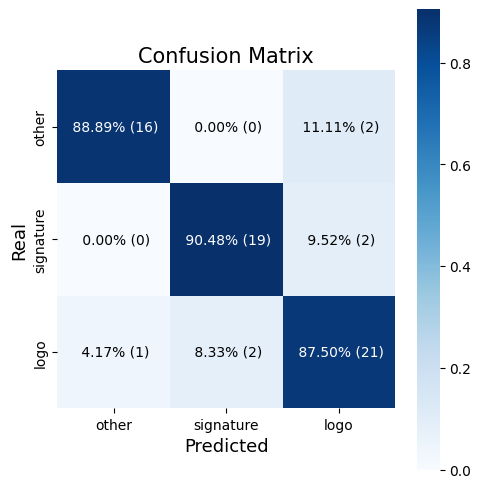

In [26]:

#################################################################
####                     Define files                        ####
#################################################################

db_path = "../../Datasets/Objects_Database/Features"

#### Features files ####

# features_name = "HOG_F(288)_img(256, 512)_O(9)_C(64)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(756)_img(256, 512)_O(9)_C(64)_B(2)_N(L2-Hys).csv"
# features_name = "HOG_F(1152)_img(256, 512)_O(9)_C(32)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(3780)_img(256, 512)_O(9)_C(32)_B(2)_N(L2-Hys).csv"
# features_name = "HOG_F(4608)_img(256, 512)_O(9)_C(16)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(16740)_img(256, 512)_O(9)_C(16)_B(2)_N(L2-Hys).csv"
# features_name = "HOG_F(18432)_img(256, 512)_O(9)_C(8)_B(1)_N(L2-Hys).csv"
# features_name = "HOG_F(70308)_img(256, 512)_O(9)_C(8)_B(2)_N(L2-Hys).csv"

features_file = "HOG_Feat(756)_img(256, 512)_O(9)_C(64)_B(2)_N(L2-Hys).csv"
features_name = features_file.split(".")[0]


#### Results file ####
results_path = f"../../Datasets/Objects_Database/Results/{features_name}"
create_dir(results_path)


#################################################################

##########################
#### Model definition ####
##########################

#################################################################
####                      SVM Model                          ####  
#################################################################


selected_model = {
        "model_name": features_name,
        "scoring": "f1_weighted",# accuracy, balanced_accuracy, f1_weighted, recall_weighted,
        "model_type": "classification",
        "model_type_2":"SVM", 
        "model": svm.SVC,
        "kfold": 5,
        "n_jobs": -1,
        "params":{
            "C": 100,
            "gamma": 0.001,
            "kernel": "rbf",
            "probability": True,
            "random_state": 21
            }
        }

K = selected_model['params']["kernel"]
C = selected_model['params']["C"]
G = selected_model['params']["gamma"]
M = selected_model['model_type_2']

#### Files to save model information ####
results_file = os.path.join(results_path, f"Test_Results_M({M})_K({K})_C({C})_G({G})_{features_name}.xlsx")
cm_file_save = os.path.join(results_path, f"Test_CM_M({M})_K({K})_C({C})_G({G})_{features_name}.pdf")

model_file = os.path.join(results_path, f"Model({M})_K({K})_C({C})_G({G})_{features_name}.joblib")
standarization_file = os.path.join(results_path, f"std_selected_train_data_204(other_signature_logo).joblib")


#################################################################

#################################################################
####                    Gradient Boosting                    ####  
#################################################################


# selected_model = {
#         "model_name": name,
#         "scoring": "f1_weighted",# accuracy, balanced_accuracy, f1_weighted, recall_weighted,
#         "model_type": "classification",
#         "M":"GB", 
#         "model": GradientBoostingClassifier,
#         "kfold": 5,
#         "n_jobs": -1, 
#         "params":{
#             "loss": "log_loss",
#             "learning_rate": 0.1,
#             "n_estimators": 1000,
#             "random_state": 21
#             }
#         }


# M = selected_model['M']
# LS = selected_model['params']["loss"]
# LR = selected_model['params']["learning_rate"]
# E = selected_model['params']["n_estimators"]


# results_file = os.path.join(results_path, f"Test_Results_M({M})_LS({LS})_LR({LR})_E({E})_{name}.xlsx")
# cm_file_save = os.path.join(results_path, f"Test_CM_M({M})_LS({LS})_LR({LR})_E({E})_{name}.pdf")

#################################################################




##########################


##########################
#### value prediction ####
##########################

evaluation_data = {
    "docid_test": "docid",
    "y_true": "y_test",
    "y_pred": "predict",
    #"y_prob": "predict_proba",
}


############################
#### Metrics definition ####
############################

evaluation_metrics = {
    
    "Accuracy" : {  "function": "Accuracy",
                    "data": ["y_true", "y_pred"],
                    "params": []
                },
    
    "Balanced_Accuracy" : {  "function": "Balanced_Accuracy",
                    "data": ["y_true", "y_pred"],
                    "params": []
                },
    
    "F1_Weighted" : {  "function": "F1_Score",
                        "data": ["y_true", "y_pred"],
                        "params": [("average", "weighted")]
                    },
    
    "Recall_Weighted" : {  "function": "Recall_Score",
                    "data": ["y_true", "y_pred"],
                    "params": [("average", "weighted")]
                },   
    
    "Kappa_Score" : {  "function": "Cohen_Kappa_Score",
                    "data": ["y_true", "y_pred"],
                    "params": []
                },   
}



#### Load features ####
features_file = os.path.join(db_path, features_file)

#### Load Features ####
features_df = pd.read_csv(features_file)
feat_cols = [col for col in features_df.columns if("hog_" in col)]

#### Train data ####
train_data_df = features_df.loc[features_df["set"]=="train", :].reset_index(drop=True)
#### Split train docid ####
docid_train = train_data_df["docid"]

#### Split train features ####
X_train = train_data_df.loc[:,feat_cols]
# X_train = np.asarray(X_train)

#### Create labels ####
label_map = {
    "logo": 0,
    "signature": 1,
    "other": 2
}
train_data_df["label"] = train_data_df["label"].map(label_map)
y_train = train_data_df["label"].copy()


#### Test Data ####
##############################
test_data_df = features_df.loc[features_df["set"]=="test", :].reset_index(drop=True)

#### Split docid ####
docid_test = test_data_df["docid"]

#### Split features ####
X_test = test_data_df.loc[:,feat_cols]
# X_test = np.asarray(X_test)

#### Create labels ####
label_map = {
    "logo": 0,
    "signature": 1,
    "other": 2
}
test_data_df["label"] = test_data_df["label"].map(label_map)
y_test = test_data_df["label"].copy()

print(f"X Shape: {X_test.shape} - Y Shape: {y_test.shape}")

#################################################################
####                     Normalize data                      ####
#################################################################

#### save normalizer ####
normalize_transfor = StandardScaler().fit(X_train)
dump(normalize_transfor, standarization_file) 

#### Load normalizer ####
# normalize_transfor = load(standarization_file)

X_train = normalize_transfor.transform(X_train)
X_test = normalize_transfor.transform(X_test)

#################################################################
####                       Train model                       ####
#################################################################
## Initialize new model ##
classifier = selected_model["model"]()
## Get deault parameters ##
parameters = classifier.get_params()

## Replace the best parameters trained ##
for key in selected_model["params"].keys():
    ## Assign best parameters ##
    parameters[key] = selected_model["params"][key]
    
## Set the new parameters ##
classifier.set_params(**parameters)
## Train model ##
classifier.fit(X_train, y_train)

#### Save trained model ####
dump(classifier, model_file) 

#### Load trained model ####
# classifier = load(model_file)



#################################################################
####                    Prediction process                   ####
#################################################################

## Dictionary to store the needed predictions ##
test_predictions_dict = {}
for key in evaluation_data.keys():
    test_predictions_dict[key] = []
        
## Perform the indicated evaluations ##
for key in evaluation_data.keys():
    if("test" in evaluation_data[key]):
        ## Save real featrues ##
        test_predictions_dict[key] = y_test.copy()
    elif("docid" in evaluation_data[key]):
        ## Save real featrues ##
        test_predictions_dict[key] = docid_test.copy()
    else:
        ## Save the predictions needed ##
        test_predictions_dict[key] = getattr(classifier, evaluation_data[key])(X_test)
    
#################################################################


#################################################################
####                      Compute metrics                    ####
#################################################################

## to store the metrics ##
metric_evaluation = MetricEvaluation()
test_metrics_results_dict = {}
## Initialize key to sabe the data ##
for key in evaluation_metrics.keys():
    test_metrics_results_dict[key] = []

for key in evaluation_metrics.keys():         
    value = evaluating(metric_evaluation, key, evaluation_metrics[key], test_predictions_dict)
    # print(key, ":",value)
    test_metrics_results_dict[key].append(value)
            
#################################################################


##############################################################
####                      Save data                    ####
##############################################################


#### Results of selected metrics ####
metrics_results_df = pd.DataFrame.from_dict(test_metrics_results_dict)

#### Predicted values for test data ####
test_data_results_df = pd.DataFrame.from_dict(test_predictions_dict)


#### Report doesn't make sense for regression ####
if(selected_model["model_type"].lower() == "regression"):
    test_report = pd.DataFrame([])
else:
    test_report, _ = report(test_data_results_df["y_true"], test_data_results_df["y_pred"])

with pd.ExcelWriter(results_file) as writer:  
    
    metrics_results_df.to_excel(writer, sheet_name="metrics", index=(False))
    test_report.to_excel(writer, sheet_name="test_report")
    test_data_results_df.to_excel(writer, sheet_name="predicted_data", index=(False))
    
#################################################################

#### Plot Confusion matrix ####
## Assign labels ##
labels = ["other", "signature", "logo"]
## Obtain data ##
y_true = test_data_results_df["y_true"]
y_pred = test_data_results_df["y_pred"]

## plot CM ##
cm = confusion_matrix_plot(y_true, y_pred, cm_file_save,labels=labels, size=5)

